In [1]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import ast
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.optimize import linear_sum_assignment

#### Repetim la inferència com al notebook anterior

In [2]:
model = YOLO('./runs/detect/train_5k_15e_v3/weights/best.pt')
image_root = "../../generador-tiquets/script_general/exports/data/complexity_5/coco/tickets/"
inference = model(image_root)
path = '../../generador-tiquets/script_general/exports/data/complexity_5/coco/bbx_products_in_ticket.csv'
df = pd.read_csv(path, dtype = {'ticket_id': str})
df[['b_1', 'b_2', 'b_3', 'b_4']] = df.apply(lambda row: pd.Series([ast.literal_eval(row['b_1']), ast.literal_eval(row['b_2']), ast.literal_eval(row['b_3']), ast.literal_eval(row['b_4'])]), axis=1)
data = []
# idx, per poder accedir a l'array de inferencia.
for idx, (ticket_id, grouped_df) in enumerate(df.groupby('ticket_id')):
    # Aquí tenim cada inferencia de cada tiquet:
    data_boxes = inference[idx].boxes.data

    # Ara agafem tots els bboxs que ha predit a dins de cada tiquet:
    # Convertim de tensor a numpy array
    data_boxes_np = data_boxes.cpu().detach().numpy()

    # Guardem en un dataframe amb la id del tiquet (aqui tenim un array de arrays on cada element és un bbox del tiquet "predicció")
    for bbx in data_boxes_np.tolist():
        data.append({
          'ticket_id': ticket_id,
          'x1': bbx[0],
          'y1': bbx[1],
          'x2': bbx[2],
          'y2': bbx[3],
          'acc': bbx[4],
          'label': bbx[5]
        })
predicts = pd.DataFrame(data)
predicts['label_name'] = predicts['label'].map(inference[0].names)
df['x1'] = df['b_1'].apply(lambda x: x[0])
df['y1'] = df['b_1'].apply(lambda x: x[1])
df['x2'] = df['b_4'].apply(lambda x: x[0])
df['y2'] = df['b_4'].apply(lambda x: x[1])


image 1/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000001.png: 640x384 5 descripcios, 5 quantitat_uds, 5 imports, 1 total, 2 preu_unitaris, 222.0ms
image 2/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000002.png: 640x384 5 descripcios, 5 quantitat_uds, 5 imports, 1 total, 2 preu_unitaris, 113.0ms
image 3/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000003.png: 640x352 8 descripcios, 6 quantitat_uds, 2 quantitat_kgs, 8 imports, 1 total, 5 preu_unitaris, 136.0ms
image 4/10 C:\Users\jaume\Script tiquets\analisis-tiquets\ocr-tiquets\bbox_detection\..\..\generador-tiquets\script_general\exports\data\complexity_5\coco\tickets\000004.png: 640x384 4 descripcios, 3 qu

#### Repetim la inferència del notebook 1_evaluate_model.ipynb

In [3]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate areas of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

# Calculem l'IoU de un valor real amb tots el predits.
def calculate_iou_matrix(boxes_true, boxes_pred):
    iou_matrix = np.zeros((len(boxes_true), len(boxes_pred)))
    for i, box_true in enumerate(boxes_true):
        for j, box_pred in enumerate(boxes_pred):
            iou_matrix[i, j] = calculate_iou(box_true, box_pred)
    return iou_matrix

boxes_pred = predicts[["x1", "y1", "x2", "y2"]].values
boxes_true = df[["x1", "y1", "x2", "y2"]].values
iou_matrix = calculate_iou_matrix(boxes_true, boxes_pred)

cost_matrix = 1 - iou_matrix
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)
df['idx'] = df.apply(lambda row: row.name, axis=1)

def pred_values(row, predicts, idxs_pred):
    idx_pred = idxs_pred[row.idx]
    row_pred = predicts.iloc[idx_pred]

    row['x1_pred'] = row_pred.x1
    row['y1_pred'] = row_pred.y1
    row['x2_pred'] = row_pred.x2
    row['y2_pred'] = row_pred.y2
    row['acc_pred'] = row_pred.acc
    row['label_pred'] = row_pred.label_name

    return row

df = df.apply(lambda row: pred_values(row, predicts, idxs_pred), axis=1)
df['label_correct'] = df['etiqueta'] == df['label_pred']



#### Relacionem cada producte amb els seus atributs. Atributs que tenim:
- Quantitat (ud i kg)
- Preu unitari (si no existeix, es a dir, està en blanc. És l'import)
- Descripció
- Import

#### Per fer-ho, ho fem de la següent manera:
1. L'únic element que tenen tots els productes es l'element descripció.
    - Per tant, agafem aquest com a principal (real) i relacionem els altres elements amb ell.
2. Relacionar descripció amb quantitat_ud
3. Relacionar descripció amb quantitat_kg
4. Relacionar descripció amb preu_unitari
5. Relacionar descripció amb import
- Relacionar-ho significa:
    - fer el `linear_sum_assignment` entre el real i el predit
    - real és la descripció i predit l'altre element
    - el que minimitzem és el valor y1 de cada bbox
    - per tant, haurem d'agafar el valor y1 de la descripció i de l'altre element
    - com que estàn en línea, relacionarà els index que estiguin a la mateixa altura
- **Problema**: Les quantitats als productes per kg, no estàn a la mateixa línea, sino que estàn a la següent, tenim el mateix problema amb les unitats, que no estàn en línea, sinó a la següent.
    - Possible solució:
        - Relacionar preus_unitaris amb quantitat_kg i un cop relacionats, als preus_unitaris en qüestió, els hi restem la mida del bbox (20px / y2-y1) i tornem a relacionar les quantitats amb preus_unitaris habent restat el bbox. Podem fer-ho amb tots els de preu_unitari o només els que hem canviat perquè ja sabem que són de quantitat_kg.

#### Ho fem amb alguns tiquets i després per tots:


In [4]:
image_root = "../../generador-tiquets/script_general/exports/data/complexity_5/coco/tickets/"

def paint_bbox_of(id):
    grouped_df = df[df['ticket_id'] == id]
    pilImg = Image.open(f"{image_root}{id}.png")
    imgdrw = ImageDraw.Draw(pilImg)
    for idx, item in grouped_df.iterrows():
        imgdrw.rectangle([(item.x1, item.y1),(item.x2, item.y2)], outline = 'red', width = 2)
        imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = 'blue', width = 2)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

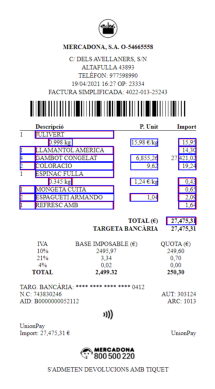

In [5]:
paint_bbox_of('000003')

In [6]:
df_3 = df[df['ticket_id'] == '000003']
df_3 = df_3[df_3['etiqueta'] != 'total'].copy()
df_3

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct
36,000003,quantitat_kg,0.998,"(99, 330)","(159, 330)","(99, 350)","(159, 350)",99.0,330,159.0,350,36,97.972397,330.262329,159.533737,349.885376,0.866024,quantitat_kg,True
37,000003,descripcio,JULIVERT,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,37,63.957455,309.791779,264.661499,329.842468,0.944530,descripcio,True
38,000003,preu_unitari,"15,98","(307.5, 330)","(377.5, 330)","(307.5, 350)","(377.5, 350)",307.5,330,377.5,350,38,307.196442,330.121155,377.110596,350.428162,0.954912,preu_unitari,True
39,000003,import,"15,95","(430, 330)","(475, 330)","(430, 350)","(475, 350)",430.0,330,475.0,350,39,429.916534,329.643524,474.791260,349.764984,0.939477,import,True
40,000003,quantitat_ud,1,"(25, 350)","(65, 350)","(25, 370)","(65, 370)",25.0,350,65.0,370,40,25.323490,349.703400,64.009750,369.938171,0.968891,quantitat_ud,True
41,000003,descripcio,LLAMÀNTOL AMERICÀ,"(65, 350)","(265, 350)","(65, 370)","(265, 370)",65.0,350,265.0,370,41,63.995625,349.928131,263.833435,370.118561,0.949669,descripcio,True
42,000003,import,"14,30","(430, 350)","(475, 350)","(430, 370)","(475, 370)",430.0,350,475.0,370,42,429.255676,349.798065,474.726318,369.845856,0.933812,import,True
43,000003,quantitat_ud,4,"(25, 370)","(65, 370)","(25, 390)","(65, 390)",25.0,370,65.0,390,43,25.534237,370.050415,64.104240,389.836121,0.966779,quantitat_ud,True
44,000003,descripcio,GAMBOT CONGELAT,"(65, 370)","(265, 370)","(65, 390)","(265, 390)",65.0,370,265.0,390,44,63.465359,369.993896,264.032379,389.880035,0.959703,descripcio,True
45,000003,preu_unitari,"6,855,26","(307.5, 370)","(377.5, 370)","(307.5, 390)","(377.5, 390)",307.5,370,377.5,390,45,307.008636,370.354187,376.782074,390.384430,0.926287,preu_unitari,True


In [7]:
Ytest = df_3[df_3['etiqueta'] == 'descripcio'].y1_pred

In [8]:
Ypred = df_3[df_3['etiqueta'] == 'quantitat_ud'].y1_pred

In [9]:
print(Ytest)
print()
print(Ypred)

37    309.791779
41    349.928131
44    369.993896
48    390.048615
52    410.018250
56    449.982971
59    470.157410
63    489.998169
Name: y1_pred, dtype: float64

40    349.703400
43    370.050415
47    389.984467
55    449.924469
58    469.603882
62    489.668091
Name: y1_pred, dtype: float64


In [10]:
Ytest.values, Ypred.values

(array([     309.79,      349.93,      369.99,      390.05,      410.02,      449.98,      470.16,         490]),
 array([      349.7,      370.05,      389.98,      449.92,       469.6,      489.67]))

#### La diferència entre Ytest i Ytest.values és que a un hi tenim l'index que pertany del dataframe original i l'altre només els valors.

In [11]:
def create_cost_matrix(Ytest, Ypred):
        cost_matrix = np.zeros((len(Ytest.values), len(Ypred.values)))

        for i, x in enumerate(Ytest.values):
            for j, y in enumerate(Ypred.values):
                cost_matrix[i, j] = abs(x - y)

        return cost_matrix

cost_matrix = create_cost_matrix(Ytest, Ypred)
cost_matrix

array([[     39.912,      60.259,      80.193,      140.13,      159.81,      179.88],
       [    0.22473,      20.122,      40.056,      99.996,      119.68,      139.74],
       [      20.29,    0.056519,      19.991,      79.931,       99.61,      119.67],
       [     40.345,      19.998,    0.064148,      59.876,      79.555,      99.619],
       [     60.315,      39.968,      20.034,      39.906,      59.586,       79.65],
       [     100.28,      79.933,      59.999,    0.058502,      19.621,      39.685],
       [     120.45,      100.11,      80.173,      20.233,     0.55353,      19.511],
       [     140.29,      119.95,      100.01,      40.074,      20.394,     0.33008]])

In [12]:
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

print("Optimal assignment of bounding boxes:")
print("Ground Truth Indices:", idxs_true)
print("Predicted Indices:", idxs_pred)

Optimal assignment of bounding boxes:
Ground Truth Indices: [1 2 3 5 6 7]
Predicted Indices: [0 1 2 3 4 5]


#### Pintem el tiquet amb la relació que ens ha fet el `linear assignment`
- Primer hem de relacionar els index que ens ha predit amb els index que corresponien al df original

In [13]:
def get_relations(idxs_true, idxs_pred):
    relacions = {}

    for i in range(len(idxs_true)):
        idx_descripcio = Ytest[Ytest == Ytest.values[idxs_true[i]]].index[0]
        idx_label = Ypred[Ypred == Ypred.values[idxs_pred[i]]].index[0]

        relacions[idx_descripcio] = idx_label

    return relacions

relacions = get_relations(idxs_true, idxs_pred)
relacions

{41: 40, 44: 43, 48: 47, 56: 55, 59: 58, 63: 62}

In [14]:
relacions_keys = list(relacions.keys())
relacions_values = list(relacions.values())
relacions_keys, relacions_values

([41, 44, 48, 56, 59, 63], [40, 43, 47, 55, 58, 62])

#### Podem obtenir l'index amb aquest mètode de baix i no tindrem problemes de repetits ja que aquests números són index de les files del dataframe original i només n'hi ha 1 per cada registre.
- Mirarem si l'index es parell o senar per pintar-lo d'un color o un altre, així estarem relacionant els bbox visualment.
- També podríem afegir un nou atribut a l'objecte relacions que fos el color (perquè fossin tots diferents)
- Hauríem de tenir una llista de colors per anar-los assignant


In [15]:
relacions_keys.index(41), relacions_values.index(55)

(0, 3)

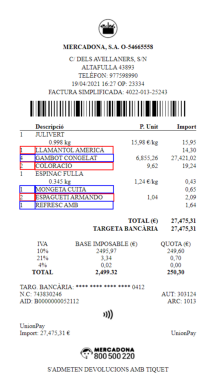

In [16]:
def pintar_relacions(relacions):
    id = '000003'

    relacions_keys = list(relacions.keys())
    relacions_values = list(relacions.values())

    grouped_df = df[df['ticket_id'] == id]
    pilImg = Image.open(f"{image_root}{id}.png")
    imgdrw = ImageDraw.Draw(pilImg)
    for idx, item in grouped_df.iterrows():
        if idx in relacions.keys():
            color = 'red' if relacions_keys.index(idx) % 2 == 0 else 'blue'
            imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = color, width = 2)
        if idx in relacions.values():
            color = 'red' if relacions_values.index(idx) % 2 == 0 else 'blue'
            imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = color, width = 2)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

pintar_relacions(relacions)

In [17]:
# Ara per altres elements (preu_unitari, quantitat_kg i import)
Ypred = df_3[df_3['etiqueta'] == 'preu_unitari'].y1_pred
# Ytest.values, Ypred.values

In [18]:
cost_matrix = create_cost_matrix(Ytest, Ypred)

In [19]:
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

# print("Optimal assignment of bounding boxes:")
# print("Ground Truth Indices:", idxs_true)
# print("Predicted Indices:", idxs_pred)

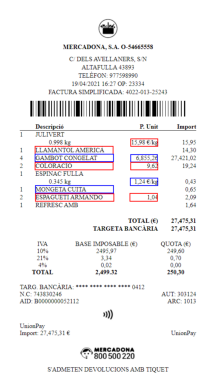

In [20]:
# Pintem igual que abans la relació:
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

In [21]:
Ypred = df_3[df_3['etiqueta'] == 'import'].y1_pred
# Ytest.values, Ypred.values

In [22]:
cost_matrix = create_cost_matrix(Ytest, Ypred)

In [23]:
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

# print("Optimal assignment of bounding boxes:")
# print("Ground Truth Indices:", idxs_true)
# print("Predicted Indices:", idxs_pred)

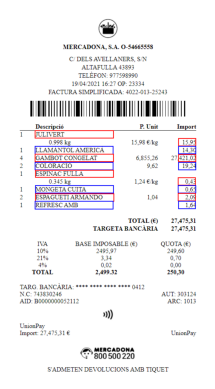

In [24]:
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

In [25]:
Ypred = df_3[df_3['etiqueta'] == 'quantitat_kg'].y1_pred
Ytest.values, Ypred.values

(array([     309.79,      349.93,      369.99,      390.05,      410.02,      449.98,      470.16,         490]),
 array([     330.26,      429.82]))

In [26]:
df_3[(df_3['etiqueta'] == 'descripcio') & ((df_3['value'] == 'JULIVERT') | (df_3['value'] == 'ESPINAC FULLA') | (df_3['value'] == 'LLAMÀNTOL AMERICÀ'))]

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct
37,000003,descripcio,JULIVERT,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,37,63.957455,309.791779,264.661499,329.842468,0.944530,descripcio,True
41,000003,descripcio,LLAMÀNTOL AMERICÀ,"(65, 350)","(265, 350)","(65, 370)","(265, 370)",65.0,350,265.0,370,41,63.995625,349.928131,263.833435,370.118561,0.949669,descripcio,True
52,000003,descripcio,ESPINAC FULLA,"(65, 410)","(265, 410)","(65, 430)","(265, 430)",65.0,410,265.0,430,52,64.203705,410.018250,264.179352,429.864044,0.937689,descripcio,True


In [27]:
df_3[df_3['etiqueta'] == 'quantitat_kg']

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct
36,000003,quantitat_kg,0.998,"(99, 330)","(159, 330)","(99, 350)","(159, 350)",99.0,330,159.0,350,36,97.972397,330.262329,159.533737,349.885376,0.866024,quantitat_kg,True
51,000003,quantitat_kg,0.345,"(99, 430)","(159, 430)","(99, 450)","(159, 450)",99.0,430,159.0,450,51,97.137917,429.820129,157.186386,450.092926,0.925927,quantitat_kg,True


#### Llemàntol americà ha d'estar més aprop que julivert:
- Comprovem el valor de Ytest - Ypred

In [28]:
julivert = df_3[df_3['value'] == 'JULIVERT'].y1_pred.values[0]
pes = df_3[df_3['value'] == '0.998'].y1_pred.values[0]
america = df_3[df_3['value'] == 'LLAMÀNTOL AMERICÀ'].y1_pred.values[0]

print("JULIVERT (Y): \t\t", julivert)
print("0.998 (Y): \t\t", pes)
print("RESULTAT: \t\t", julivert - pes)
print()
print("LLAMÀNTOL AMERICÀ (Y): \t", america)
print("0.998 (Y): \t\t", pes)
print("RESULTAT: \t\t",  america - pes)
print()
print("ABS:")
print()
print("JULIVERT (Y): \t\t", julivert)
print("0.998 (Y): \t\t", pes)
print("RESULTAT: \t\t", abs(julivert - pes))
print()
print("LLAMÀNTOL AMERICÀ (Y): \t", america)
print("0.998 (Y): \t\t", pes)
print("RESULTAT: \t\t",  abs(america - pes))

JULIVERT (Y): 		 309.7917785644531
0.998 (Y): 		 330.2623291015625
RESULTAT: 		 -20.470550537109375

LLAMÀNTOL AMERICÀ (Y): 	 349.9281311035156
0.998 (Y): 		 330.2623291015625
RESULTAT: 		 19.665802001953125

ABS:

JULIVERT (Y): 		 309.7917785644531
0.998 (Y): 		 330.2623291015625
RESULTAT: 		 20.470550537109375

LLAMÀNTOL AMERICÀ (Y): 	 349.9281311035156
0.998 (Y): 		 330.2623291015625
RESULTAT: 		 19.665802001953125


- El que està passant és que realment el pes està a la mateixa distància de una descripció que de una altre (20px), quan YOLO fa la predicció, té un marge d'error, el qual ens està fent que aquest bbox estigui més aprop de la descripció de baix que la de dalt (que es la que li pertoca).

#### Una possible solució sería `"normalitzar"` les coordenades que estàn en una segona línia per tal que les detectes bé. Hauríem de seguir els següents passos:
- Normalitzar els elements amb etiqueta quantitat_kg i relacionar-les amb la descripció.
- Per trobar la quantitat, relacionem la quantitat_kg sense normalitzar amb els preus_unitaris i com que prèviament els haurem relacionat amb la descripció, ja ho tindrem tot.

#### Efectivament, ho mostra malament:

In [29]:
cost_matrix = create_cost_matrix(Ytest, Ypred)
# cost_matrix

In [30]:
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

print("Optimal assignment of bounding boxes:")
print("Ground Truth Indices:", idxs_true)
print("Predicted Indices:", idxs_pred)

Optimal assignment of bounding boxes:
Ground Truth Indices: [1 4]
Predicted Indices: [0 1]


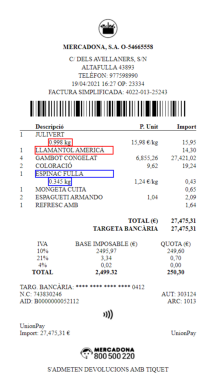

In [31]:
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

#### Fem aquest proccès de normalitzar per detectar
- Normalitzar: restar 20px a la quantitat_kg perquè estigui alineat amb la descripció que li pertocaría

In [32]:
Ypred = df_3[df_3['etiqueta'] == 'quantitat_kg'].y1_pred
Ytest.values, Ypred.values -20

(array([     309.79,      349.93,      369.99,      390.05,      410.02,      449.98,      470.16,         490]),
 array([     310.26,      409.82]))

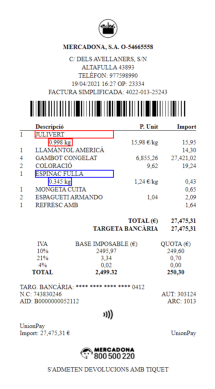

In [33]:
cost_matrix = create_cost_matrix(Ytest, Ypred -20)
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

#### Funciona millor

#### Ara relacionem els preus_unitaris amb la quantitat_kg (sense normalitzar)

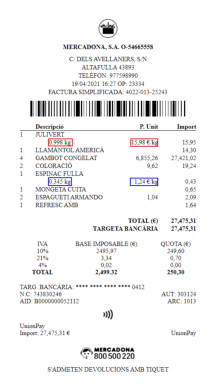

In [34]:
Ytest = df_3[df_3['etiqueta'] == 'quantitat_kg'].y1_pred
Ypred = df_3[df_3['etiqueta'] == 'preu_unitari'].y1_pred
cost_matrix = create_cost_matrix(Ytest, Ypred)
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

In [35]:
# Sabem que el 38 correspon al 36 i sabem amb quina descripció té aquest
# Podem tirar enrrere les relacions
relacions

{36: 38, 51: 53}

In [36]:
df.iloc[53]

ticket_id              000003
etiqueta         preu_unitari
value                    1,24
b_1              (307.5, 430)
b_2              (377.5, 430)
b_3              (307.5, 450)
b_4              (377.5, 450)
x1                      307.5
y1                        430
x2                      377.5
y2                        450
idx                        53
x1_pred            306.983917
y1_pred            430.082489
x2_pred             377.08371
y2_pred            450.213287
acc_pred             0.924573
label_pred       preu_unitari
label_correct            True
Name: 53, dtype: object

#### Mirem els preus_unitaris que no són d'aquests que acabem de trobar

In [37]:
preus_unitaris = df_3[df_3['etiqueta'] == 'preu_unitari'].y1_pred
preus_unitaris

38    330.121155
45    370.354187
49    390.307495
53    430.082489
60    469.746674
Name: y1_pred, dtype: float64

In [38]:
preus_unitaris_ud = preus_unitaris.drop([38, 53])
preus_unitaris_ud

45    370.354187
49    390.307495
60    469.746674
Name: y1_pred, dtype: float64

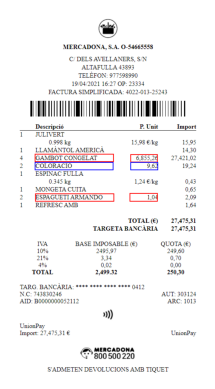

In [39]:
Ytest = df_3[df_3['etiqueta'] == 'descripcio'].y1_pred
Ypred = preus_unitaris_ud
Ytest.values, Ypred.values
cost_matrix = create_cost_matrix(Ytest, Ypred)
idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)
relacions = get_relations(idxs_true, idxs_pred)
pintar_relacions(relacions)

#### Relacionem en aquest ordre:
- 1: els que estàn pre relacionats amb quantitat_kg (dos files)
- treiem de la llista de preus_unitaris els que hem trobat en el primer pas i deprés fem el pas 2.
- 2: els altres que correspondràn a productes unitaris (una fila)

#### Apliquem el que hem après del `linear_sum_assignment` per crear el dataframe relacionant la informació.
```python
products = [
          {
              'descripcio': 'BAIETA PAL SUAU',
              'quantitat': '3',
              'preu_unitari': '0,85',
              'import': '2,54'
          },
          {                      
              'descripcio': 'SECRET DE PORC',
              'quantitat': '1',
              'preu_unitari': '2,60',
              'import': '2,60'
          },
          {
              ···
          }
]

df = pd.DataFrame(data)
```

In [40]:
df.head(8)

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,x1,y1,x2,y2,idx,x1_pred,y1_pred,x2_pred,y2_pred,acc_pred,label_pred,label_correct
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",25.0,310,65.0,330,0,25.222412,310.099579,64.155037,329.693146,0.967603,quantitat_ud,True
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",65.0,310,265.0,330,1,64.721504,309.848114,264.486877,329.872040,0.947316,descripcio,True
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)",430.0,310,475.0,330,2,430.516418,310.148834,474.845642,329.813446,0.941037,import,True
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",25.0,330,65.0,350,3,25.560492,329.949554,64.124382,349.788818,0.939450,quantitat_ud,True
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",65.0,330,265.0,350,4,64.104164,329.893341,265.951294,350.118927,0.931638,descripcio,True
5,000001,import,"2,04","(430, 330)","(475, 330)","(430, 350)","(475, 350)",430.0,330,475.0,350,5,430.005035,329.761200,474.755981,349.953613,0.942795,import,True
6,000001,quantitat_ud,3,"(25, 350)","(65, 350)","(25, 370)","(65, 370)",25.0,350,65.0,370,6,24.904161,349.783386,64.217171,369.886719,0.951834,quantitat_ud,True
7,000001,descripcio,MIG CONILL,"(65, 350)","(265, 350)","(65, 370)","(265, 370)",65.0,350,265.0,370,7,63.567722,349.924316,265.158539,369.904419,0.967669,descripcio,True


#### Relacionarem les dades de la següent manera:
- Afegir una columna al dataframe original `df`. En la què:
    - A les files que siguin `etiqueta = descripció` i afegirem l'bojecte:
    - `{'etiqueta': 'idx'}`. Ex:
    - `{'quantitat_ud':'0', 'import': '2', 'preu_unitari': '14'}`
    - Quedaria així:
    - `{ 4: {'quantitat_ud':'0', 'import': '2', 'preu_unitari': '14'} }`
    - Vol dir:
    - al index 4 del dataframe, hi ha una descripció. A aquesta descripció li pertanyen l'index 0 del mateix dataframe (és una quantitat_ud), també al index 2 hi ha l'import d'aquella descripció. I, així amb tots els elements que hi hagin a dins l'objecte.
- Queda així:
```python
ticket_info = {
    'ticket_id': { # Aquí va el id de la descripció, si hi ha un 4, vol dir que el row amb id 4, hi ha una descripció, el qual la seva informació està dins l'ojbecte
        'descripcio_id': {
            'unitats': 'index',
            'preu_unitari': 'index',
            'import': 'index'
        },
    }
}
```
- Així, sabrem per cada descripció, quines són les altres files amb els atributs que li corresponen. i Finalment, podrem crear l'array que necessitem (anomenat anteriorment).

- Per passar de l'index que ens dona el linear assignment a l'index real ho fem amb:
    - `Ytest[Ytest == Ytest.values[0]].index`

In [41]:
df_3 = df[df['ticket_id'] == '000003']
df_3 = df_3[df_3['etiqueta'] != 'total'].copy()

In [42]:
Ytest = df_3[df_3['etiqueta'] == 'descripcio'].y1_pred
Ypred = df_3[df_3['etiqueta'] == 'quantitat_ud'].y1_pred

In [43]:
Ytest.values, Ypred.values

(array([     309.79,      349.93,      369.99,      390.05,      410.02,      449.98,      470.16,         490]),
 array([      349.7,      370.05,      389.98,      449.92,       469.6,      489.67]))

In [44]:
Ytest[Ytest == Ytest.values[0]].index

Index([37], dtype='int64')

In [45]:
df.iloc[37].y1_pred

309.7917785644531

In [46]:
ticket_info = {ticket_id: {} for ticket_id, _ in df.groupby('ticket_id')}
ticket_info

{'000001': {},
 '000002': {},
 '000003': {},
 '000004': {},
 '000005': {},
 '000006': {},
 '000007': {},
 '000008': {},
 '000009': {},
 '000010': {}}

In [47]:
for ticket_id, grouped_df in df.groupby('ticket_id'):

    g_df = grouped_df[grouped_df['etiqueta'] != 'total'].copy()
    # total_row = grouped_df[grouped_df['etiqueta'] == 'total']

    Ytest = g_df[g_df['etiqueta'] == 'descripcio'].y1_pred

    for label in ['import', 'quantitat_ud', 'quantitat_kg']:
        Ypred = g_df[g_df['etiqueta'] == label].y1_pred

        if label == 'quantitat_kg':
            Ypred -= 20

        cost_matrix = create_cost_matrix(Ytest, Ypred)

        idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

        for i in range(len(idxs_true)):
            idx_descripcio = Ytest[Ytest == Ytest.values[idxs_true[i]]].index[0] #[0] perquè retornaba un objecte Index

            # Crear el atribut descripcio_id (que és el id d'aquesta descripció)
            if idx_descripcio not in ticket_info[ticket_id]:
                ticket_info[ticket_id][idx_descripcio] = {}

            idx_label = Ypred[Ypred == Ypred.values[idxs_pred[i]]].index[0]

            ticket_info[ticket_id][idx_descripcio][label] = idx_label

# Això està fora i he tallat el bucle i l'he tornat a començar perquè sinó no em deixava
# modificar l'objecte ticket_info, donava error : RuntimeError: dictionary changed size during iteration
#
copied_items = dict(ticket_info[ticket_id]).copy()

# preu unitari dels kg
for ticket_id, grouped_df in df.groupby('ticket_id'):

    g_df = grouped_df[grouped_df['etiqueta'] != 'total'].copy()

    Ytest = g_df[g_df['etiqueta'] == 'quantitat_kg'].y1_pred
    Ypred = g_df[g_df['etiqueta'] == 'preu_unitari'].y1_pred

    cost_matrix = create_cost_matrix(Ytest, Ypred)
    idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

    relacions = get_relations(idxs_true, idxs_pred)

    for k_1, v_1 in relacions.items():
        # Busquem a quina descripció (key del diccionari interior de ticket_info['00000X])
        # Té a dins
        for k_2, v_2 in copied_items.items():
            x = v_2.copy()
            for v_3 in x.values():
                if v_3 == k_1:
                    ticket_info[ticket_id][k_2]['preu_unitari'] = v_1.copy()

    # preu unitari dels ud
    preus_unitaris = g_df[g_df['etiqueta'] == 'preu_unitari'].y1_pred
    preus_unitaris_ud = preus_unitaris.drop(relacions.values())

    Ytest = g_df[g_df['etiqueta'] == 'descripcio'].y1_pred
    Ypred = preus_unitaris_ud

    cost_matrix = create_cost_matrix(Ytest, Ypred)
    idxs_true, idxs_pred = linear_sum_assignment(cost_matrix)

    for i in range(len(idxs_true)):
        idx_descripcio = Ytest[Ytest == Ytest.values[idxs_true[i]]].index[0] #[0] perquè retornaba un objecte Index

        # Crear el atribut descripcio_id (que és el id d'aquesta descripció)
        if idx_descripcio not in ticket_info[ticket_id]:
            ticket_info[ticket_id][idx_descripcio] = {}

        idx_label = Ypred[Ypred == Ypred.values[idxs_pred[i]]].index[0]

        ticket_info[ticket_id][idx_descripcio]['preu_unitari'] = idx_label

ticket_info

{'000001': {1: {'import': 2, 'quantitat_ud': 0},
  4: {'import': 5, 'quantitat_ud': 3},
  7: {'import': 9, 'quantitat_ud': 6, 'preu_unitari': 8},
  11: {'import': 13, 'quantitat_ud': 10, 'preu_unitari': 12},
  15: {'import': 16, 'quantitat_ud': 14}},
 '000002': {19: {'import': 20, 'quantitat_ud': 18},
  22: {'import': 24, 'quantitat_ud': 21, 'preu_unitari': 23},
  26: {'import': 28, 'quantitat_ud': 25, 'preu_unitari': 27},
  30: {'import': 31, 'quantitat_ud': 29},
  33: {'import': 34, 'quantitat_ud': 32}},
 '000003': {37: {'import': 39, 'quantitat_kg': 36},
  41: {'import': 42, 'quantitat_ud': 40},
  44: {'import': 46, 'quantitat_ud': 43, 'preu_unitari': 45},
  48: {'import': 50, 'quantitat_ud': 47, 'preu_unitari': 49},
  52: {'import': 54, 'quantitat_kg': 51},
  56: {'import': 57, 'quantitat_ud': 55},
  59: {'import': 61, 'quantitat_ud': 58, 'preu_unitari': 60},
  63: {'import': 64, 'quantitat_ud': 62}},
 '000004': {67: {'import': 69, 'quantitat_ud': 66, 'preu_unitari': 68},
  71: {'i

#### Ara creem el dataframe inicial que comentàvem amb l'array `products`

```python
products = [
          # Hem d'afegir ticket_id, ja que els fem tots de cop.
          # Quam fem l'script per fer inferència no caldrà perquè serà un únic tiquet.
          {
              'descripcio': 'BAIETA PAL SUAU',
              'quantitat': '3',
              'preu_unitari': '0,85',
              'import': '2,54'
          },
          {                      
              'descripcio': 'SECRET DE PORC',
              'quantitat': '1',
              'preu_unitari': '2,60',
              'import': '2,60'
          },
          {
              ···
          }
]

df = pd.DataFrame(data)
```


In [48]:
data = []
for ticket_id in df.ticket_id.unique():
    tiquet_obj = ticket_info[ticket_id]

    for key, value in tiquet_obj.items():
        descripcio_id = key
        quantitat_ud_id = value.get('quantitat_ud', None)
        quantitat_kg_id = value.get('quantitat_kg', None)
        preu_unitari_id = value.get('preu_unitari', None)
        import_id = value.get('import', None)

        data.append({
            'ticket_id': ticket_id,
            'descripcio': df.iloc[descripcio_id].value,
            'quantitat': df.iloc[quantitat_ud_id].value if quantitat_ud_id is not None else df.iloc[quantitat_kg_id].value,
            'preu_unitari': df.iloc[preu_unitari_id].value if preu_unitari_id is not None else df.iloc[import_id].value,
            'import': df.iloc[import_id].value
        })

df_related_products = pd.DataFrame(data)
df_related_products

,ticket_id,descripcio,quantitat,preu_unitari,import
0,000001,DESODORANT CURA,1,"1,69","1,69"
1,000001,ACTIVADOR,1,"2,04","2,04"
2,000001,MIG CONILL,3,"4,03","12,08"
3,000001,CANELONS,2,"2,31","4,62"
4,000001,PAPER D'ALUMINI,1,"3,51","3,51"
5,000002,BLAT MORO DOLÇ,1,"1,26","1,26"
6,000002,PASTÍS INFANTIL,4,"7,70","30,80"
7,000002,PIZZA CAMPEROLA,2,"2,20","4,40"
8,000002,ANELLES POTA,1,"4,35","4,35"
9,000002,LLEIXIU AMB,1,"1,19","1,19"


#### Fem una inspecció visual per veure si està bé:

Dataframe predit: 
  ticket_id       descripcio quantitat preu_unitari import
0    000001  DESODORANT CURA         1         1,69   1,69
1    000001        ACTIVADOR         1         2,04   2,04
2    000001       MIG CONILL         3         4,03  12,08
3    000001         CANELONS         2         2,31   4,62
4    000001  PAPER D'ALUMINI         1         3,51   3,51
Imatge del tiquet:


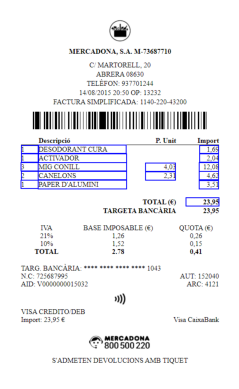


--------------------------------

Dataframe predit: 
  ticket_id       descripcio quantitat preu_unitari import
5    000002   BLAT MORO DOLÇ         1         1,26   1,26
6    000002  PASTÍS INFANTIL         4         7,70  30,80
7    000002  PIZZA CAMPEROLA         2         2,20   4,40
8    000002     ANELLES POTA         1         4,35   4,35
9    000002      LLEIXIU AMB         1         1,19   1,19
Imatge del tiquet:


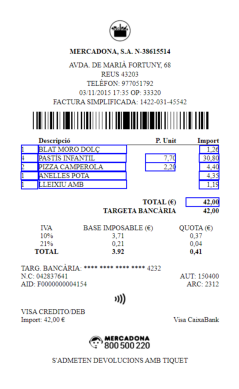


--------------------------------

Dataframe predit: 
   ticket_id         descripcio quantitat preu_unitari     import
10    000003           JULIVERT     0.998        15,95      15,95
11    000003  LLAMÀNTOL AMERICÀ         1        14,30      14,30
12    000003    GAMBOT CONGELAT         4     6,855,26  27,421,02
13    000003          COLORACIÓ         2         9,62      19,24
14    000003      ESPINAC FULLA     0.345         0,43       0,43
15    000003      MONGETA CUITA         1         0,65       0,65
16    000003  ESPAGUETI ARMANDO         2         1,04       2,09
17    000003        REFRESC AMB         1         1,64       1,64
Imatge del tiquet:


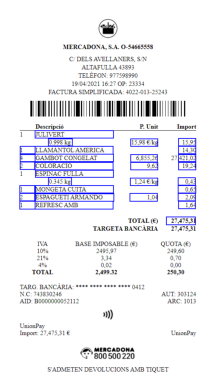


--------------------------------

Dataframe predit: 
   ticket_id     descripcio quantitat preu_unitari import
18    000004       FORMATGE         5         2,07  10,35
19    000004  GELAT TARONJA         5         1,65   8,25
20    000004        RODANXA         1         3,18   3,18
21    000004   PATATES TALL     1.339         1,28   1,28
Imatge del tiquet:


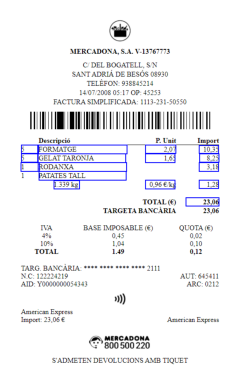


--------------------------------

Dataframe predit: 
   ticket_id        descripcio quantitat preu_unitari    import
22    000005  NECESSER SANTORO         1         7,26      7,26
23    000005       XORIÇO GALL         3         2,42      7,26
24    000005      REFRESC COLA         1         1,72      1,72
25    000005     LLAGOSTÍ CUIT         1     1,083,56  1,083,56
Imatge del tiquet:


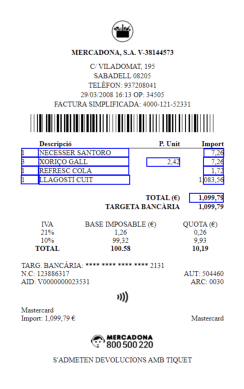


--------------------------------

Dataframe predit: 
   ticket_id          descripcio quantitat preu_unitari import
26    000006    FORMATGE D'UNTAR         1         2,18   2,18
27    000006           COLORACIÓ         2         4,23   8,47
28    000006  COLÒNIA HOME IKIRU         1         9,68   9,68
Imatge del tiquet:


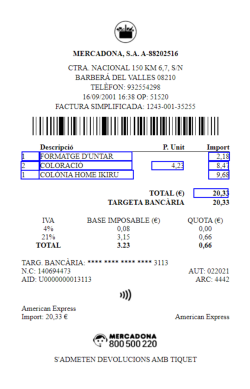


--------------------------------

Dataframe predit: 
   ticket_id     descripcio quantitat preu_unitari import
29    000007  GELAT TARONJA         1         1,65   1,65
30    000007          PÈSOL     1.412         1,68   1,68
31    000007      CALAMARSÓ         4         4,12  16,50
Imatge del tiquet:


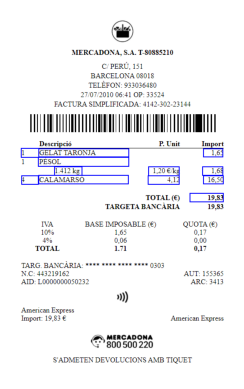


--------------------------------

Dataframe predit: 
   ticket_id    descripcio quantitat preu_unitari import
32    000008  REFRESC COLA         1         0,29   0,29
33    000008     CROQUETES         1         1,09   1,09
Imatge del tiquet:


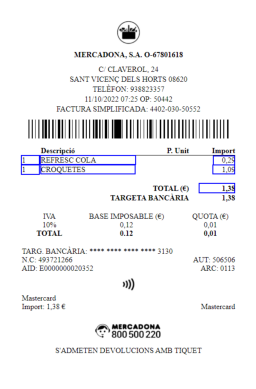


--------------------------------

Dataframe predit: 
   ticket_id       descripcio quantitat preu_unitari import
34    000009  PASTÍS INFANTIL         1        11,00  11,00
35    000009   GELAT AMETLLAT         3         2,31   6,93
36    000009    ARRÒS PRECUIT         1         1,72   1,72
37    000009      GELAT TORRÓ         1         2,75   2,75
38    000009      ARRÒS NEGRE         1         2,37   2,37
39    000009   LLOM HACENDADO         1         6,05   6,05
Imatge del tiquet:


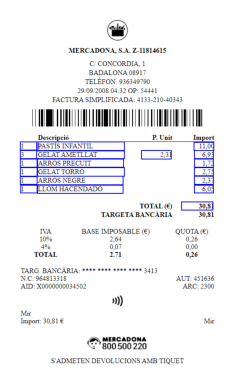


--------------------------------

Dataframe predit: 
   ticket_id descripcio quantitat preu_unitari import
40    000010    LASANYA         4         4,40  17,60
Imatge del tiquet:


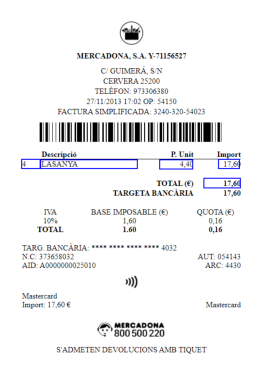


--------------------------------



In [49]:
for ticket_id, grouped_df in df.groupby('ticket_id'):
    print("Dataframe predit: ")
    print(df_related_products[df_related_products['ticket_id'] == ticket_id])
    pilImg = Image.open(f"{image_root}{ticket_id}.png")
    imgdrw = ImageDraw.Draw(pilImg)

    for idx, item in grouped_df.iterrows():
        imgdrw.rectangle([(item.x1_pred, item.y1_pred),(item.x2_pred, item.y2_pred)], outline = 'blue', width = 2)

    print("Imatge del tiquet:")
    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

    print()
    print("--------------------------------")
    print()